# 使用预训练好的模型搭建 [**DETR**]

In [1]:
from PIL import Image 
import requests 
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format = 'retina'

import torch 
from torch import nn 
from torchvision.models import resnet50 
import torchvision.transforms as T 
torch.set_grad_enabled(False);

## [**DETR**]实现

In [2]:
class DETR(nn.Module):
    """ 
    
    """

    def __init__(self, num_classes, hidden_dim=256, nheads=8, 
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # 创建res50作为backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # 重新设计fc 作为转化层接入transformer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # 使用pytorch定义好的 transformer
        self.transformer = nn.Transformer(hidden_dim, nheads, 
                                          num_encoder_layers, num_decoder_layers)
        
        # 预测头 额外多的一类作为空集背景类
        # 原始的 DETR linear_bbox layer 是一个3层的MLP 
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # 输出的位置编码 (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # 空间位置编码
        # 原始的 DETR 使用 sine 位置编码
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        h = self.conv(x)   # (batch_size, hidden_dim, 7, 7)

        # 构造位置编码
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1)
        ], dim=-1).flatten(0, 1).unsqueeze(1)   # ((H*W), 1, hidden_dim)

        # transformer 输出 (batch_szie, 100, hidden_dim)
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),   # (49, batch_szie, hidden_dim)
                             self.query_pos.unsqueeze(1)).transpose(0, 1) # (100, 1, hidden_dim) 

        # 返回字典 100个框的class预测结果和bounding_box预测结果
        return {'pred_logits': self.linear_class(h),         # (batch_szie, 100, cls +1)
                'pred_boxs': self.linear_bbox(h).sigmoid()}  # (batch_szie, 100, 4)

### 载入训练好的参数

In [3]:
detr = DETR(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

/home/shilin/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


小测试

In [4]:
input = torch.rand(1, 3, 224, 224)
detr_test = DETR(91)
output = detr_test(input)

# output['pred_logits'].shape
proba = output['pred_logits'].softmax(-1)[0, :, :-1]
proba.shape

torch.Size([100, 91])

## 图片 transformer 预测可视化

In [5]:
# coco类别
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# 视觉可视化颜色
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [6]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 输出后处理
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5*w), (y_c - 0.5*h),
         (x_c + 0.5*w), (y_c + 0.5*h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

小测试

In [7]:
bbox = torch.tensor([[0.3, 0.4, 0.2, 0.2]])
bbox.shape
size = (100, 100)
a, b = size
y = rescale_bboxes(bbox, size)
y

tensor([[20.0000, 30.0000, 40.0000, 50.0000]])

In [8]:
def detect(im, model, transform):
    img = transform(im).unsqueeze(0)

    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, "model only supoort up to 1600 pixels"

    outputs = model(img)

    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]   # (100, 91)
    keep = probas.max(-1).values > 0.7   # 拿出一百个预测框中每个置信度最大且大于0.7的

    bboxes_scaled = rescale_bboxes(outputs['pred_boxs'][0, keep], im.size)

    return probas[keep], bboxes_scaled

## 使用 DETR

torch.Size([1, 91]) torch.Size([1, 4])


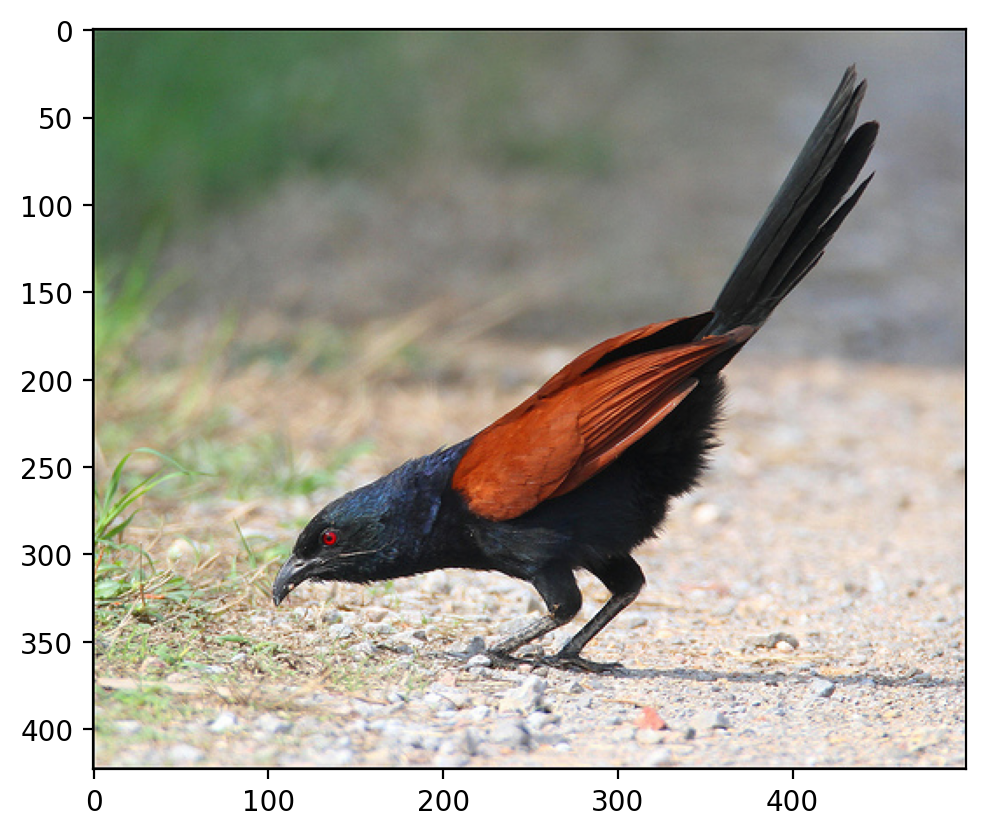

In [9]:
im = Image.open('../data/bird.JPEG')
plt.imshow(im)

scores, boxes = detect(im, detr, transform)
print(scores.shape, boxes.shape)

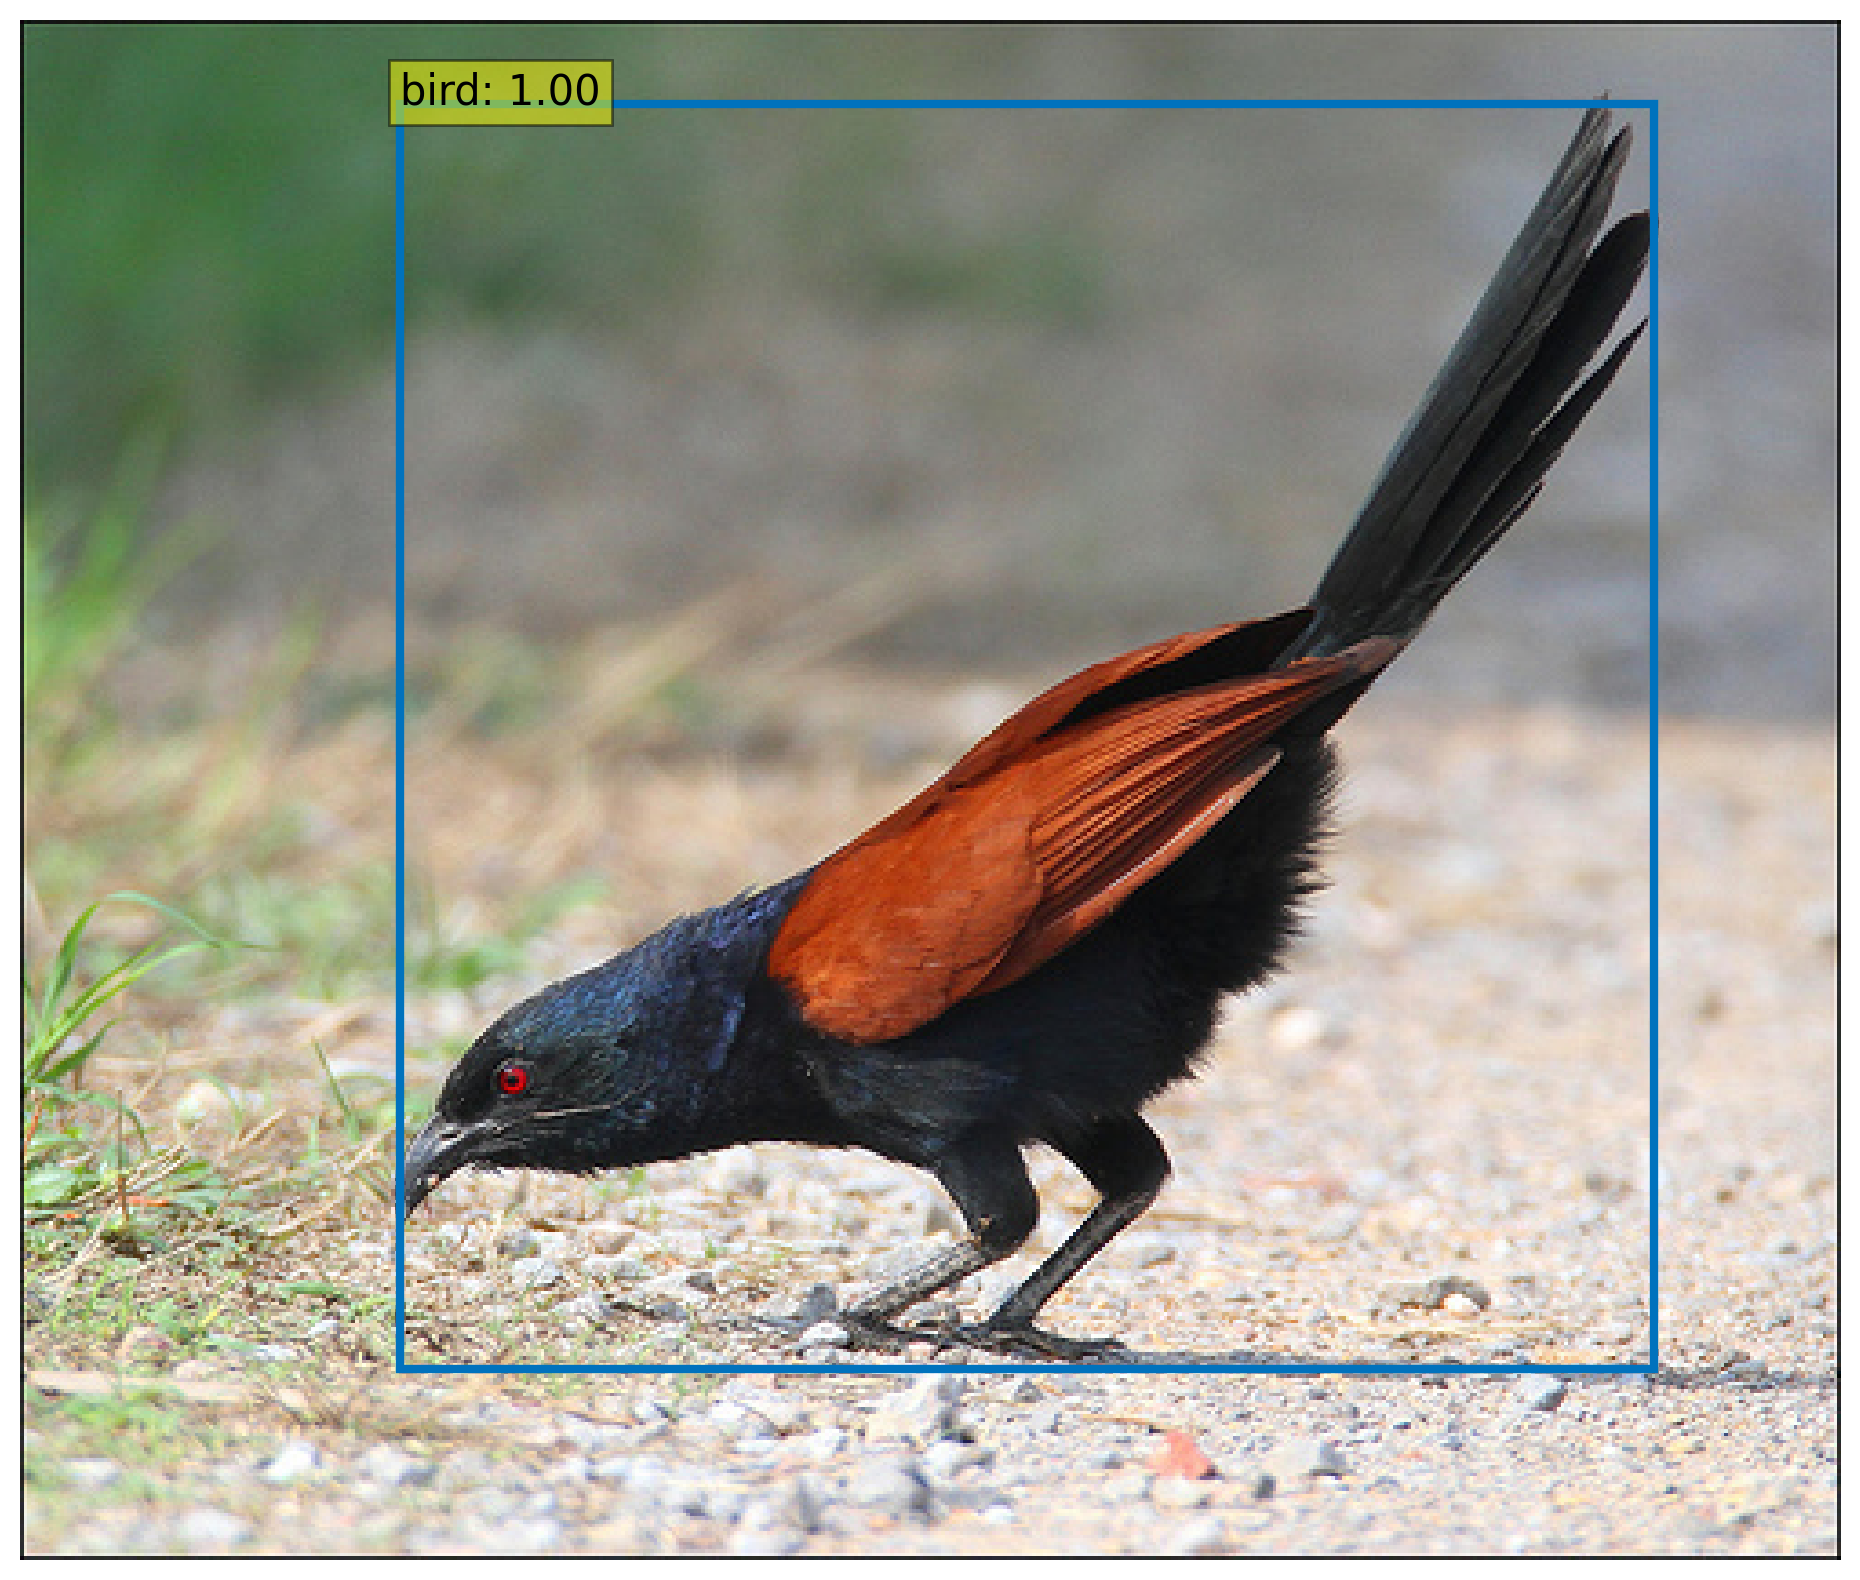

In [10]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

plot_results(im, scores, boxes)